# Project Outline - Water Quality

- Water Quality Dataset from Kaggel - https://www.kaggle.com/adityakadiwal/water-potability

- Predicting podability based on existing features without potability feature

- Testing our predictions on original database potability feature

- Create a feature that is MORE then binary for potability

In [65]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pydotplus
import scipy.stats       as stats
import plotly.express as px

from six                  import StringIO
from IPython.display      import Image
from data.ds_models       import ds_models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline                import Pipeline
from sklearn.impute                  import SimpleImputer, KNNImputer
from sklearn.preprocessing           import StandardScaler, OneHotEncoder, normalize
from sklearn.model_selection         import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics                 import mean_squared_error, mean_squared_log_error, accuracy_score
from sklearn.metrics                 import plot_confusion_matrix, classification_report

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.tree         import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble     import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble     import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm          import SVC

import warnings
warnings.filterwarnings('ignore')

# Data Exploration and Cleaning

In [66]:
df = pd.read_csv('data/water_potability.csv')

In [67]:
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [68]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = df.apply(stats.iqr)
df_out = df[~((X < (Q1-1.5*IQR)) | (X > Q3+1.5*IQR)).any(axis=1)]
df_out

ph    Hardness        Solids  Chloramines     Sulfate  \
0          NaN  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246         NaN   
2     8.099124  224.236259  19909.541732     9.275884         NaN   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3270  6.069616  186.659040  26138.780191     7.747547  345.700257   
3272  7.808856  193.553212  17329.802160     8.061362         NaN   
3273  9.419510  175.762646  33155.578218     7.350233         NaN   
3274  5.126763  230.603758  11983.869376     6.303357         NaN   
3275  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3270    415.886955       12.067620        60.419921   3.669712           1  
3272    392.449580       19.903225              NaN   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3046 rows x 10 columns]

### Raw Potability Histogram

(array([1998.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1278.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

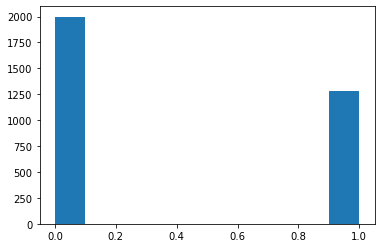

In [69]:
plt.hist(df['Potability'])

### Cleaning NaN values

In [70]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [71]:
df_scrub = df.dropna()
df_scrub.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

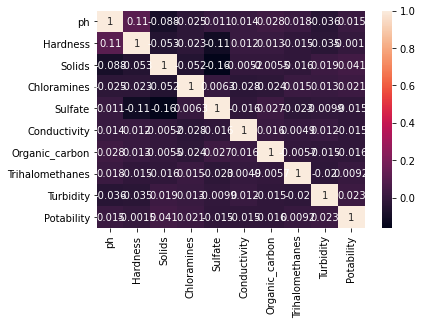

In [72]:
sns.heatmap(df_scrub.corr(), annot=True);

In [73]:
df_scrub.corr()

ph  Hardness    Solids  Chloramines   Sulfate  \
ph               1.000000  0.108948 -0.087615    -0.024768  0.010524   
Hardness         0.108948  1.000000 -0.053269    -0.022685 -0.108521   
Solids          -0.087615 -0.053269  1.000000    -0.051789 -0.162769   
Chloramines     -0.024768 -0.022685 -0.051789     1.000000  0.006254   
Sulfate          0.010524 -0.108521 -0.162769     0.006254  1.000000   
Conductivity     0.014128  0.011731 -0.005198    -0.028277 -0.016192   
Organic_carbon   0.028375  0.013224 -0.005484    -0.023808  0.026776   
Trihalomethanes  0.018278 -0.015400 -0.015668     0.014990 -0.023347   
Turbidity       -0.035849 -0.034831  0.019409     0.013137 -0.009934   
Potability       0.014530 -0.001505  0.040674     0.020784 -0.015303   

                 Conductivity  Organic_carbon  Trihalomethanes  Turbidity  \
ph                   0.014128        0.028375         0.018278  -0.035849   
Hardness             0.011731        0.013224        -0.015400  -0.034831   
Solids              -0.005198       -0.005484        -0.015668   0.019409   
Chloramines         -0.028277       -0.023808         0.014990   0.013137   
Sulfate             -0.016192        0.026776        -0.023347  -0.009934   
Conductivity         1.000000        0.015647         0.004888   0.012495   
Organic_carbon       0.015647        1.000000        -0.005667  -0.015428   
Trihalomethanes      0.004888       -0.005667         1.000000  -0.020497   
Turbidity            0.012495       -0.015428        -0.020497   1.000000   
Potability          -0.015496       -0.015567         0.009244   0.022682   

                 Potability  
ph                 0.014530  
Hardness          -0.001505  
Solids             0.040674  
Chloramines        0.020784  
Sulfate           -0.015303  
Conductivity      -0.015496  
Organic_carbon    -0.015567  
Trihalomethanes    0.009244  
Turbidity          0.022682  
Potability         1.000000

In [74]:
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


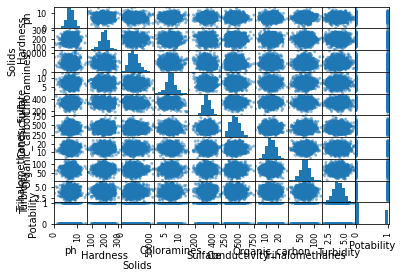

In [75]:
pd.plotting.scatter_matrix(df_scrub);

## Removing Outliers

In [76]:
X = df_scrub.drop(columns=['Potability'], axis=1)

### Clean Potability Histogram

In [77]:
#plt.hist(df1['Potability'])

# Data Instantiation

### Raw Data

In [78]:
X = df.drop(columns=['Potability'], axis=1)
y = df['Potability']

### Dropping NaNs Data

In [79]:
df_dn = df.dropna()
X_dn  = df_dn.drop(columns=['Potability'], axis=1)
y_dn  = df_dn['Potability']

### Dropping Outliers Data

In [80]:



X_do = df_out.drop(columns=['Potability'], axis=1)
y_do = df_out['Potability']

### Dropping Outliers No NaNs

In [81]:
df_scrub = df.dropna()
df_scrub.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [82]:
Q1 = df_scrub.quantile(0.25)
Q3 = df_scrub.quantile(0.75)
IQR = df_scrub.apply(stats.iqr)
df_dn_do = df_scrub[~((X < (Q1-1.5*IQR)) | (X > Q3+1.5*IQR)).any(axis=1)]
df_dn_do

ph    Hardness        Solids  Chloramines     Sulfate  \
3      8.316766  214.373394  22018.417441     8.059332  356.886136   
4      9.092223  181.101509  17978.986339     6.546600  310.135738   
5      5.584087  188.313324  28748.687739     7.544869  326.678363   
6     10.223862  248.071735  28749.716544     7.513408  393.663396   
7      8.635849  203.361523  13672.091764     4.563009  303.309771   
...         ...         ...           ...          ...         ...   
3264   5.893103  239.269481  20526.666156     6.349561  341.256362   
3265   8.197353  203.105091  27701.794055     6.472914  328.886838   
3267   8.989900  215.047358  15921.412018     6.297312  312.931022   
3268   6.702547  207.321086  17246.920347     7.708117  304.510230   
3270   6.069616  186.659040  26138.780191     7.747547  345.700257   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
5       280.467916        8.399735        54.917862   2.559708           0  
6       283.651634       13.789695        84.603556   2.672989           0  
7       474.607645       12.363817        62.798309   4.401425           0  
...            ...             ...              ...        ...         ...  
3264    403.617560       18.963707        63.846319   4.390702           1  
3265    444.612724       14.250875        62.906205   3.361833           1  
3267    390.410231        9.899115        55.069304   4.613843           1  
3268    329.266002       16.217303        28.878601   3.442983           1  
3270    415.886955       12.067620        60.419921   3.669712           1  

[1794 rows x 10 columns]

In [83]:
X_dn_do = df_dn_do.drop(columns=['Potability'], axis=1)
y_dn_do = df_dn_do['Potability']

In [84]:
scaler  = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

In [85]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [86]:
df_a = pd.DataFrame(df_scaled)

In [87]:
df_a.columns =['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']

In [88]:
px.scatter(df_a,
           title='Relationship Between Potable and Non-Potable Water')

# Model Instantiations

## Gaussian Naive Bayes

In [89]:
#model = GaussianNB()
#model = BaggingClassifier(GaussianNB())
#model = AdaBoostClassifier(GaussianNB())

## KNeighbors Classifier

In [90]:
#model = KNeighborsClassifier()
#knc_grid   = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}
#model      = GridSearchCV(KNeighborsClassifier(), knc_grid, scoring='accuracy', verbose=1)
#model      = AdaBoostClassifier(KNeighborsClassifier())

## Logistic Regression

In [91]:
#model = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs', multi_class='auto')
#logreg_grid = {'C': [1, 2, 3], 'solver': [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]}
#model       = GridSearchCV(LogisticRegression(), logreg_grid, scoring='accuracy', verbose=1)

## Decision Tree Classifier

In [92]:
#model = DecisionTreeClassifier()
#dtc_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5]}
#model    = GridSearchCV(DecisionTreeClassifier(), dtc_grid, scoring='accuracy', verbose=1)

## Bagging Classifier

In [93]:
#model = BaggingClassifier()
#bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
#model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

## Random Forest Classifier

In [94]:
#model = RandomForestClassifier()
#rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
#            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
#model    = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

## Adaptive Boosting Classifier

In [95]:
#model = AdaBoostClassifier()

## Gradient Boosting Classifier

In [96]:
#model = GradientBoostingClassifier()

## Support Vector Classification

In [97]:
#model = SVC()
#svc_grid = {'C': [1, 2, 3], 'kernel': [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]}
#model    = GridSearchCV(SVC(), svc_grid, scoring='accuracy', verbose=1)

# Model Testing 

### Bagging Classifier - NaNs Filled w/KNN - Gridsearch - 65% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   20.5s finished


Bagging Classifier - NaNs w/KNN- Gridsearch Train Data Confusion Matrix:



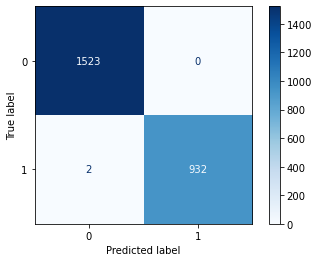

Bagging Classifier - NaNs w/KNN- Gridsearch Test Data Confusion Matrix:



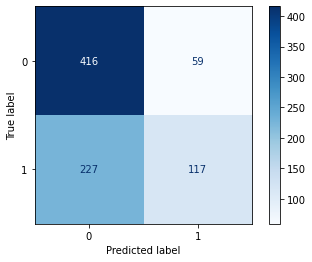

Bagging Classifier - NaNs w/KNN- Gridsearch Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Bagging Classifier - NaNs w/KNN- Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.65      0.88      0.74       475
           1       0.66      0.34      0.45       344

    accuracy                           0.65       819
   macro avg       0.66      0.61      0.60       819
weighted avg       0.65      0.65      0.62       819



In [116]:
bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

bc_gs   = ds_models(model, X, y, model_name='Bagging Classifier - NaNs w/KNN- Gridsearch',
                    output='class', imputer=True)


In [117]:
bc_gs

GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Bagging Classifier - Dropped NaNs - 68% Test Accuracy

Bagging Classifier - Dropped NaNs Train Data Confusion Matrix:



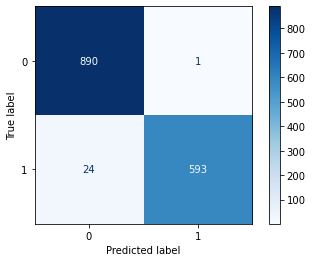

Bagging Classifier - Dropped NaNs Test Data Confusion Matrix:



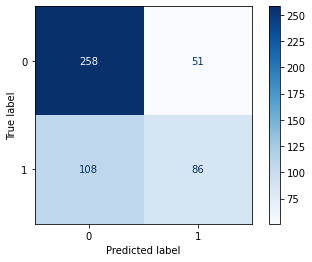

Bagging Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       891
           1       1.00      0.96      0.98       617

    accuracy                           0.98      1508
   macro avg       0.99      0.98      0.98      1508
weighted avg       0.98      0.98      0.98      1508

Bagging Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       309
           1       0.63      0.44      0.52       194

    accuracy                           0.68       503
   macro avg       0.67      0.64      0.64       503
weighted avg       0.68      0.68      0.67       503



In [118]:
model = BaggingClassifier()

bc_dn = ds_models(model, X_dn, y_dn, model_name='Bagging Classifier - Dropped NaNs',
                  output='class')


In [119]:
bc_dn

BaggingClassifier()

### Bagging Classifier - Dropped NaNs - Gridsearch - 70% Test Accuracy

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   16.7s finished


Bagging Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



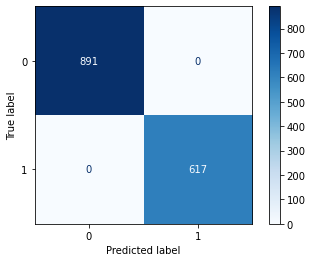

Bagging Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



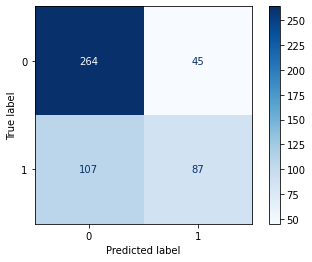

Bagging Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Bagging Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       309
           1       0.66      0.45      0.53       194

    accuracy                           0.70       503
   macro avg       0.69      0.65      0.66       503
weighted avg       0.69      0.70      0.68       503



In [147]:
bc_grid  = {'n_estimators': [10, 20, 30, 40, 50, 60], 'oob_score':['True', 'False']}
model    = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

bc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Bagging Classifier - Dropped NaNs - Gridsearch',
                     output='class')


In [121]:
bc_dn_gs

GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Bagging Classifier - Dropped Outliers - 66 - % Test Accuracy

Bagging Classifier - No Outliers, NaNs Filled Train Data Confusion Matrix:



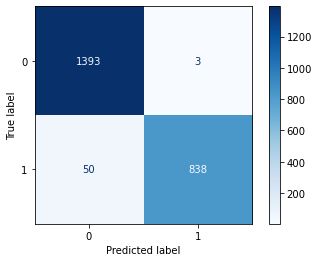

Bagging Classifier - No Outliers, NaNs Filled Test Data Confusion Matrix:



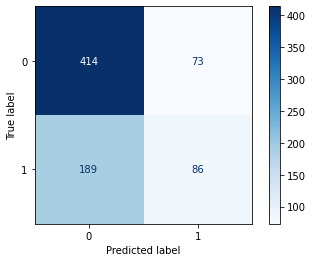

Bagging Classifier - No Outliers, NaNs Filled Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1396
           1       1.00      0.94      0.97       888

    accuracy                           0.98      2284
   macro avg       0.98      0.97      0.98      2284
weighted avg       0.98      0.98      0.98      2284

Bagging Classifier - No Outliers, NaNs Filled Test Report:

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       487
           1       0.54      0.31      0.40       275

    accuracy                           0.66       762
   macro avg       0.61      0.58      0.58       762
weighted avg       0.63      0.66      0.63       762



In [122]:
model = BaggingClassifier()

bc_dn = ds_models(model, X_do, y_do, model_name='Bagging Classifier - No Outliers, NaNs Filled',
                  imputer=True, output='class')

### Bagging Classifier - No Outliers, No NaNs - 65% Test Accuracy

Bagging Classifier - No Outliers, No NaNs Train Data Confusion Matrix:



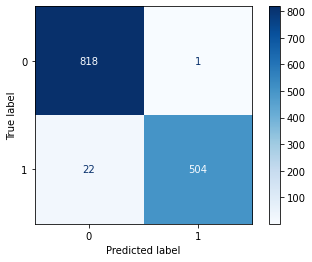

Bagging Classifier - No Outliers, No NaNs Test Data Confusion Matrix:



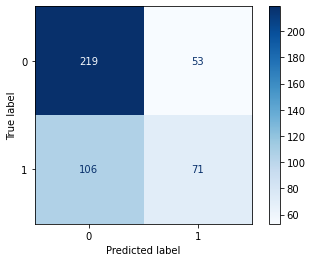

Bagging Classifier - No Outliers, No NaNs Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       819
           1       1.00      0.96      0.98       526

    accuracy                           0.98      1345
   macro avg       0.99      0.98      0.98      1345
weighted avg       0.98      0.98      0.98      1345

Bagging Classifier - No Outliers, No NaNs Test Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.73       272
           1       0.57      0.40      0.47       177

    accuracy                           0.65       449
   macro avg       0.62      0.60      0.60       449
weighted avg       0.63      0.65      0.63       449



In [123]:
model = BaggingClassifier()

bc_dn = ds_models(model, X_dn_do, y_dn_do, model_name='Bagging Classifier - No Outliers, No NaNs',
                  output='class')

### Random Forest Classifier - NaNs Filled w/KNN - 66% Test Accuracy

Random Forest Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



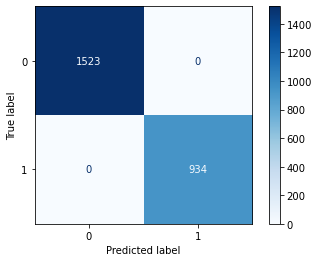

Random Forest Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



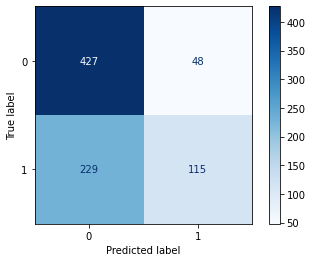

Random Forest Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Random Forest Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.65      0.90      0.76       475
           1       0.71      0.33      0.45       344

    accuracy                           0.66       819
   macro avg       0.68      0.62      0.60       819
weighted avg       0.67      0.66      0.63       819

Feature Importances:

[0.13350011 0.12144365 0.11128038 0.11131957 0.13175572 0.10115222
 0.09906439 0.09598274 0.09450122]


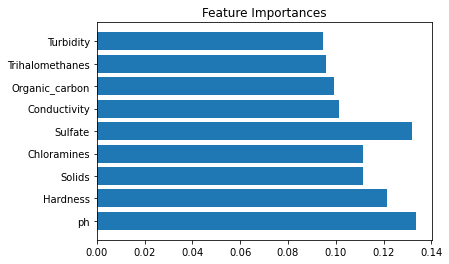

In [124]:
model = RandomForestClassifier()

rfc   = ds_models(model, X, y, model_name='Random Forest Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True, fi=True)


In [125]:
rfc

RandomForestClassifier()

### Random Forest Classifier - NaNs Filled w/KNN - Gridsearch - 63% Test Accuracy

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.6min finished


Random Forest Classifier - NaNs w/KNN - Gridsearch Train Data Confusion Matrix:



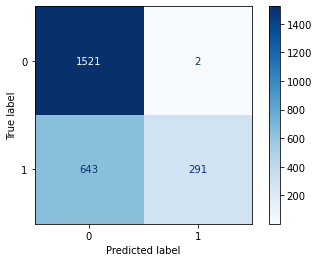

Random Forest Classifier - NaNs w/KNN - Gridsearch Test Data Confusion Matrix:



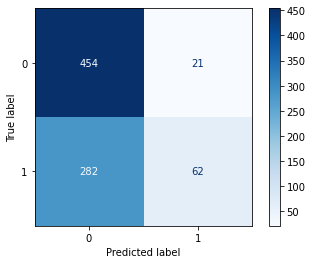

Random Forest Classifier - NaNs w/KNN - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.70      1.00      0.83      1523
           1       0.99      0.31      0.47       934

    accuracy                           0.74      2457
   macro avg       0.85      0.66      0.65      2457
weighted avg       0.81      0.74      0.69      2457

Random Forest Classifier - NaNs w/KNN - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.62      0.96      0.75       475
           1       0.75      0.18      0.29       344

    accuracy                           0.63       819
   macro avg       0.68      0.57      0.52       819
weighted avg       0.67      0.63      0.56       819



In [140]:
rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
model    = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

rfc_gs   = ds_models(model, X, y, model_name='Random Forest Classifier - NaNs w/KNN - Gridsearch', 
                     output='class', imputer=True)


In [127]:
rfc_gs

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Random Forest Classifier - Dropped NaNs - 67% Test Accuracy

Random Forest Classifier - Dropped NaNs Train Data Confusion Matrix:



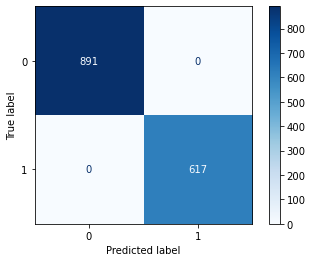

Random Forest Classifier - Dropped NaNs Test Data Confusion Matrix:



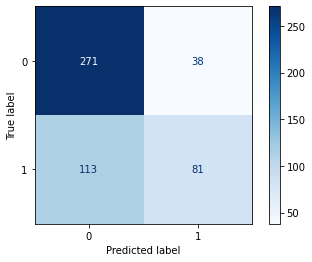

Random Forest Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Random Forest Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.71      0.88      0.78       309
           1       0.68      0.42      0.52       194

    accuracy                           0.70       503
   macro avg       0.69      0.65      0.65       503
weighted avg       0.70      0.70      0.68       503



In [128]:
model  = RandomForestClassifier()

rfc_dn = ds_models(model, X_dn, y_dn, model_name='Random Forest Classifier - Dropped NaNs',
                   output='class')

In [129]:
rfc_dn

RandomForestClassifier()

### Random Forest Classifier - Dropped NaNs - Gridsearch - 68% Test Accuracy

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.1min finished


Random Forest Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



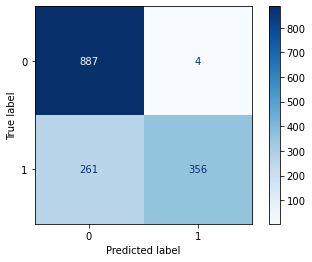

Random Forest Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



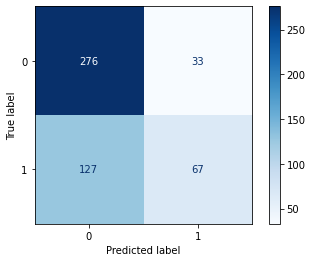

Random Forest Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       891
           1       0.99      0.58      0.73       617

    accuracy                           0.82      1508
   macro avg       0.88      0.79      0.80      1508
weighted avg       0.86      0.82      0.81      1508

Random Forest Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.68      0.89      0.78       309
           1       0.67      0.35      0.46       194

    accuracy                           0.68       503
   macro avg       0.68      0.62      0.62       503
weighted avg       0.68      0.68      0.65       503



In [130]:
rfc_grid  = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
model     = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

rfc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Random Forest Classifier - Dropped NaNs - Gridsearch', 
                      output='class')

In [131]:
rfc_dn_gs

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Random Forest Classifier - Dropped Outliers, NaNs Filled - 67% Test Accuracy

Random Forest Classifier - Dropped Outliers Train Data Confusion Matrix:



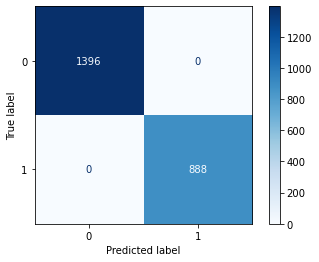

Random Forest Classifier - Dropped Outliers Test Data Confusion Matrix:



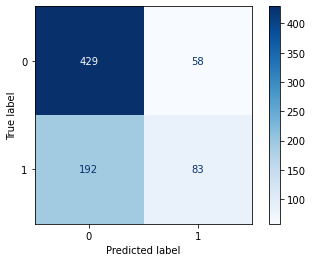

Random Forest Classifier - Dropped Outliers Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1396
           1       1.00      1.00      1.00       888

    accuracy                           1.00      2284
   macro avg       1.00      1.00      1.00      2284
weighted avg       1.00      1.00      1.00      2284

Random Forest Classifier - Dropped Outliers Test Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       487
           1       0.59      0.30      0.40       275

    accuracy                           0.67       762
   macro avg       0.64      0.59      0.59       762
weighted avg       0.65      0.67      0.64       762

Feature Importances:

[0.12811877 0.11762744 0.11128902 0.11145928 0.13322673 0.10067334
 0.09764179 0.09873359 0.10123004]


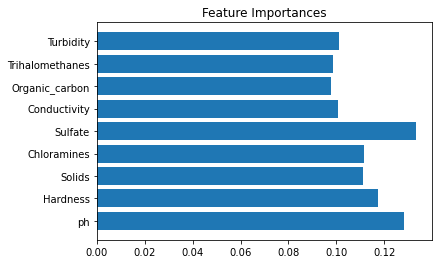

In [132]:
model = RandomForestClassifier()

rfc   = ds_models(model, X_do, y_do, model_name='Random Forest Classifier - Dropped Outliers',
                  output='class', imputer=True, fi=True)

### ### Random Forest Classifier - Dropped Outliers, Dropped NaNs - 68 % Test Accuracy

Random Forest Classifier - Dropped Outliers & Dropped NaNs Train Data Confusion Matrix:



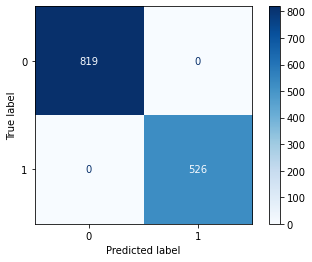

Random Forest Classifier - Dropped Outliers & Dropped NaNs Test Data Confusion Matrix:



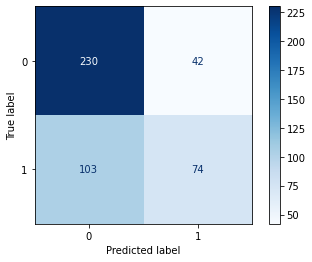

Random Forest Classifier - Dropped Outliers & Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       819
           1       1.00      1.00      1.00       526

    accuracy                           1.00      1345
   macro avg       1.00      1.00      1.00      1345
weighted avg       1.00      1.00      1.00      1345

Random Forest Classifier - Dropped Outliers & Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       272
           1       0.64      0.42      0.51       177

    accuracy                           0.68       449
   macro avg       0.66      0.63      0.63       449
weighted avg       0.67      0.68      0.66       449

Feature Importances:

[0.1357005  0.11576655 0.10925155 0.11203037 0.14321526 0.09976856
 0.09494148 0.0974521  0.09187363]


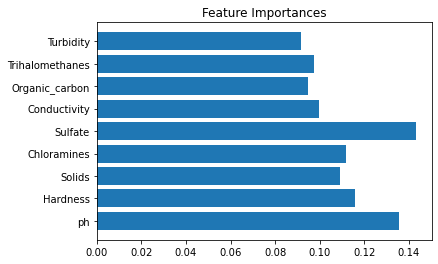

In [133]:
model = RandomForestClassifier()

rfc   = ds_models(model, X_dn_do, y_dn_do, model_name='Random Forest Classifier - Dropped Outliers & Dropped NaNs',
                  output='class', fi=True)

### Gradient Boosting Classifier - NaNs Filled w/KNN - 63% Test Accuracy

Gradient Boosting Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



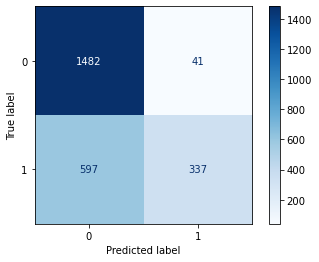

Gradient Boosting Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



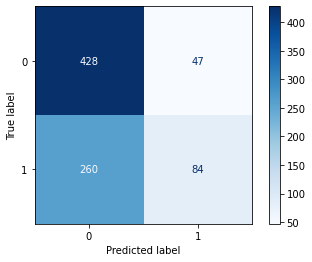

Gradient Boosting Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1523
           1       0.89      0.36      0.51       934

    accuracy                           0.74      2457
   macro avg       0.80      0.67      0.67      2457
weighted avg       0.78      0.74      0.71      2457

Gradient Boosting Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.62      0.90      0.74       475
           1       0.64      0.24      0.35       344

    accuracy                           0.63       819
   macro avg       0.63      0.57      0.54       819
weighted avg       0.63      0.63      0.58       819

Feature Importances:

[0.22436834 0.11168245 0.11792056 0.10052001 0.20691309 0.0709867
 0.05839374 0.05172595 0.05748917]


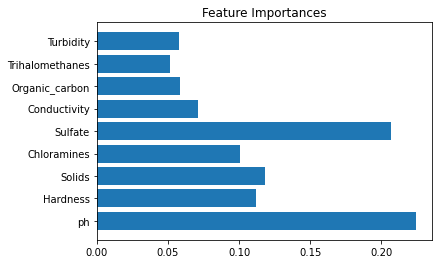

In [134]:
model = GradientBoostingClassifier()

gbc   = ds_models(model, X, y, model_name='Gradient Boosting Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True, fi=True)


In [135]:
gbc

GradientBoostingClassifier()

### Gradient Boosting Classifier - Dropped NaNs - 64% Test Accuracy

Gradient Boosting Classifier - Dropped NaNs Train Data Confusion Matrix:



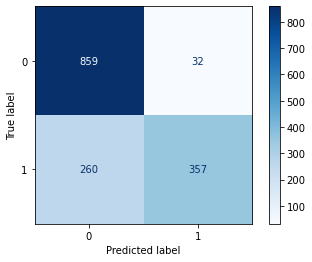

Gradient Boosting Classifier - Dropped NaNs Test Data Confusion Matrix:



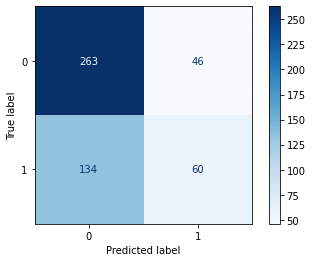

Gradient Boosting Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       891
           1       0.92      0.58      0.71       617

    accuracy                           0.81      1508
   macro avg       0.84      0.77      0.78      1508
weighted avg       0.83      0.81      0.80      1508

Gradient Boosting Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.66      0.85      0.75       309
           1       0.57      0.31      0.40       194

    accuracy                           0.64       503
   macro avg       0.61      0.58      0.57       503
weighted avg       0.63      0.64      0.61       503

Feature Importances:

[0.25450094 0.1057856  0.07952622 0.11521245 0.201175   0.04445371
 0.07302402 0.06652175 0.05980032]


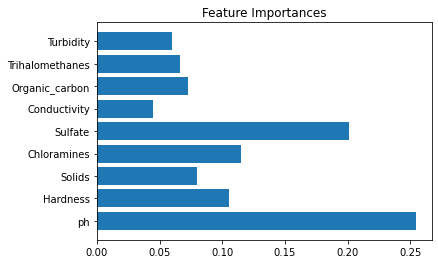

In [136]:
model  = GradientBoostingClassifier()

gbc_dn = ds_models(model, X_dn, y_dn, model_name='Gradient Boosting Classifier - Dropped NaNs',
                   output='class', fi=True)


In [137]:
gbc_dn

GradientBoostingClassifier()

### Gradient Boosting Classifier - Dropped Outliers & NaNs - 67% Test Accuracy

Gradient Boosting Classifier - Dropped NaNs Dropped Outliers Train Data Confusion Matrix:



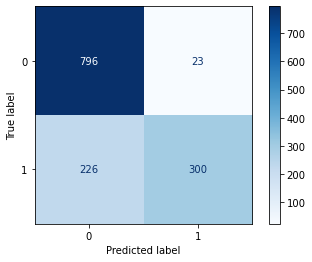

Gradient Boosting Classifier - Dropped NaNs Dropped Outliers Test Data Confusion Matrix:



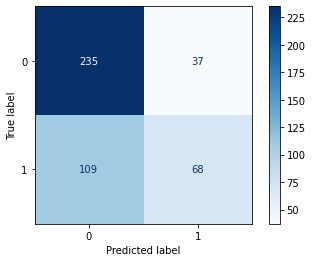

Gradient Boosting Classifier - Dropped NaNs Dropped Outliers Train Report:

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       819
           1       0.93      0.57      0.71       526

    accuracy                           0.81      1345
   macro avg       0.85      0.77      0.79      1345
weighted avg       0.84      0.81      0.80      1345

Gradient Boosting Classifier - Dropped NaNs Dropped Outliers Test Report:

              precision    recall  f1-score   support

           0       0.68      0.86      0.76       272
           1       0.65      0.38      0.48       177

    accuracy                           0.67       449
   macro avg       0.67      0.62      0.62       449
weighted avg       0.67      0.67      0.65       449

Feature Importances:

[0.18300835 0.11438875 0.09388362 0.14051418 0.21436066 0.07932315
 0.05429752 0.06208399 0.05813979]


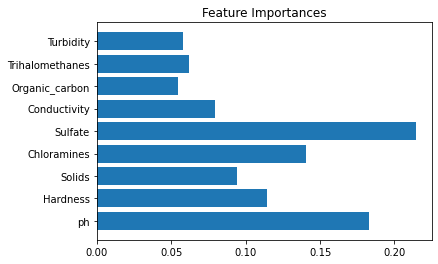

In [138]:
model  = GradientBoostingClassifier()

gbc_dn = ds_models(model, X_dn_do, y_dn_do, model_name='Gradient Boosting Classifier - Dropped NaNs Dropped Outliers',
                   output='class', fi=True)


### Gradient Boosting Classifier - Dropped Outliers, Filled NaNs - 66% Test Accuracy

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Train Data Confusion Matrix:



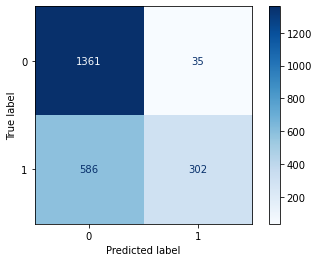

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Test Data Confusion Matrix:



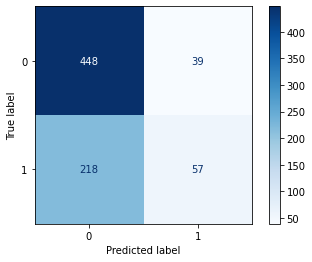

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Train Report:

              precision    recall  f1-score   support

           0       0.70      0.97      0.81      1396
           1       0.90      0.34      0.49       888

    accuracy                           0.73      2284
   macro avg       0.80      0.66      0.65      2284
weighted avg       0.78      0.73      0.69      2284

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Test Report:

              precision    recall  f1-score   support

           0       0.67      0.92      0.78       487
           1       0.59      0.21      0.31       275

    accuracy                           0.66       762
   macro avg       0.63      0.56      0.54       762
weighted avg       0.64      0.66      0.61       762

Feature Importances:

[0.24583176 0.09158014 0.12577973 0.08955235 0.19253489 0.08507786
 0.06433275 0.05529215 0.05001836]


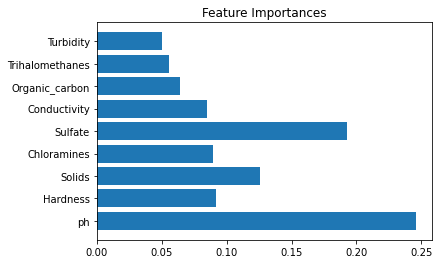

In [139]:
model  = GradientBoostingClassifier()

gbc_dn = ds_models(model, X_do, y_do, model_name='Gradient Boosting Classifier - Dropped Outliers, Filled NaNs',
                   imputer=True, output='class', fi=True)
